In [5]:
'''
Notebook specifically for fine-grained analysis of results
e.g., Spandan's histogram idea 
(Note, code is messy and reuses some functions originally written in eval_analysis file) 
'''

import imageio
import numpy as np
import os

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pandas as pd
import numpy as np

In [6]:
main_results_dir = '/om/user/katiemc/occupancy_networks/out/unconditional'
num_training_objs = [1,2,100,1000,4000]
obj_types = ['chairs'] 
reconstruction_eval_splits = ['train', 'test']

In [7]:
obj_type = "chairs" 
num_objs = 4000
split = "train"
result_dir = f'{main_results_dir}/{obj_type}{num_objs}/generation/{split}/'
print(f'\nCurrently looking at {num_objs}, {split}')
df = pd.read_pickle(result_dir + 'eval_input_full.pkl')
df.head(3)


Currently looking at 4000, train


,accuracy (mesh),accuracy2 (mesh),chamfer-L1 (mesh),chamfer-L2 (mesh),class id,class name,completeness (mesh),completeness2 (mesh),iou (mesh),modelname,normals (mesh),normals accuracy (mesh),normals completeness (mesh)
idx,,,,,,,,,,,,,
0,0.070646,0.006742,0.085436,0.010770,03001627,chair,0.100225,0.014799,0.037229,1007e20d5e811b308351982a6e40cf41,0.561300,0.600265,0.522335
1,0.044989,0.003237,0.068222,0.008439,03001627,chair,0.091456,0.013642,0.057106,1013f70851210a618f2e765c4a8ed3d,0.705847,0.743912,0.667781
2,0.064132,0.007135,0.050596,0.004956,03001627,chair,0.037060,0.002777,0.166862,1015e71a0d21b127de03ab2a27ba7531,0.698410,0.653590,0.743230


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2abba6cf15d0>]],
      dtype=object)

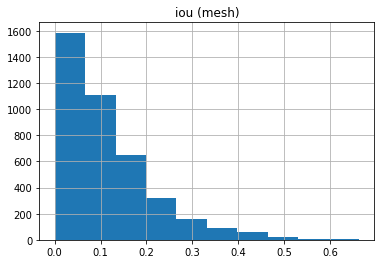

In [8]:
attr = 'iou (mesh)'
df.hist(attr)

In [9]:
# create multi-panel plot comparing histograms across sample number  
rows = 1
cols = len(num_training_objs)
attr = 'iou (mesh)'

f = plt.figure(figsize=(10, 4), dpi=600)
gs0 = gridspec.GridSpec(rows, cols, figure=f)

for x in range(rows):
    for y in range(cols):
        ax = f.add_subplot(gs0[x, y])
        num_objs = num_training_objs[y]
        result_dir = f'{main_results_dir}/{obj_type}{num_objs}/generation/{split}/'
        print(f'\nCurrently looking at {num_objs}, {split}')
        df = pd.read_pickle(result_dir + 'eval_input_full.pkl')
        df.hist(attr,ax=ax,bins=range(0,1))
        if x ==0: ax.set_title(f'{num_objs}')
plt.xlabel("IoU")
plt.title("Sample Size vs. Volumeteric IoU")
plt.close(f)
f.tight_layout()
f.savefig(f'{obj_type}_hist_{split}.png', bbox='tight', bbox_inches='tight', pad_inches=0.)


Currently looking at 1, train

Currently looking at 2, train

Currently looking at 100, train

Currently looking at 1000, train

Currently looking at 4000, train


In [10]:
# fine-grained analysis of the best/worst k objs per model

analyze_nums = [100, 1000, 4000]
k = 20 
worst_models = {}
best_models = {}

for num_objs in analyze_nums: 
    result_dir = f'{main_results_dir}/{obj_type}{num_objs}/generation/{split}/'
    print(f'\nCurrently looking at {num_objs}, {split}')
    df = pd.read_pickle(result_dir + 'eval_input_full.pkl')
    worst_models[num_objs] = list(df.sort_values(by=[attr],ascending=True)['modelname'])[:k]
    best_models[num_objs] = list(df.sort_values(by=[attr],ascending=False)['modelname'])[:k]


Currently looking at 100, train

Currently looking at 1000, train

Currently looking at 4000, train


In [11]:
# check proportion of best + worst that have overlap 
# use set intersection 
k_worst_overlap = set(worst_models[100]).intersection(set(worst_models[1000]))#, set(worst_models[4000]))
print("Worst Fit Objs Overlap: " + str(len(k_worst_overlap)/k))

k_best_overlap = set(best_models[100]).intersection(set(best_models[1000]))#, set(best_models[4000]))
print("Best Fit Objs Overlap: " + str(len(k_best_overlap)/k))

Worst Fit Objs Overlap: 0.0
Best Fit Objs Overlap: 0.05


In [70]:
k_worst_overlap

{'11e0f0dfd3d0b22130ddb6ead95f49cc'}

In [18]:
import cv2
def plot_gt(obj_name, ax,
            view_file = '023.jpg', shapenet_dir='/om/user/katiemc/occupancy_networks/data/ShapeNet/03001627/'):
    
    #img = imageio.imread(f'{shapenet_dir}{obj_name}/img_choy2016/{view_file}')
    img = cv2.imread(f'{shapenet_dir}{obj_name}/img_choy2016/{view_file}')
    ax.imshow(img)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_frame_on(False)
    ax.tick_params(top=False, left=False, bottom=False, right=False)

In [23]:
# multi-panel plot for the 20 best/worst (note: fixed for 20 currently)
rows = 4
cols = 5
fit_types = ["Best", "Worst"]
fit_dir = "./chair_best_worst_fits/"
for num_objs in analyze_nums: 
    for fit_type in fit_types: 
        idx = 0 
        f = plt.figure(figsize=(6,4), dpi=600)
        gs0 = gridspec.GridSpec(rows, cols, figure=f)
        for x in range(rows):
            for y in range(cols):
                ax = f.add_subplot(gs0[x, y])
                if fit_type == "Worst": plot_gt(worst_models[num_objs][idx], ax)
                else: plot_gt(best_models[num_objs][idx], ax)
                idx += 1 
                if x == 0 and y == 2: ax.set_title(f'{fit_type} Fits: {num_objs}')#, fontsize=18)
        plt.axis('off')
        plt.close(f)
        f.tight_layout()
        f.savefig(f'{fit_dir}fitObjs_{num_objs}_{fit_type}.png', bbox='tight', bbox_inches='tight', pad_inches=0.)